In [2]:
# from sandbox.celine_knowledge_graph import *
# from sandbox.spacy_experiments import *
# from sandbox.neuralcoref_experiments import *
# from bert_embedding import BertEmbedding

In [1]:
import sys
import spacy
import neuralcoref
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

nlp = spacy.load("en_core_web_lg")
neuralcoref.add_to_pipe(nlp)

In [2]:
def clean_src(s):
    s = s.split()
    # remove everything from "-lrb-" to "-rrb-"
    s2 = []
    in_paren = False
    for ixw, w in enumerate(s):
        if(w=="-lrb-"):
            in_paren=True
        elif(w=='-rrb-'):
            in_paren=False
        elif(w=="-lsb-" or w=="-rsb-"):
            continue
        elif(len(w) > 1 and w[0] == '\''):
            s2[-1] = s2[-1]+w
        elif not in_paren and not (w == '<t>' or w == '</t>'):
            s2.append(w)
    return ' '.join(s2)

def clean_gen(s):
    s = s.split()
    # remove everything from "-lrb-" to "-rrb-"
    s2 = []
    in_paren = False
    for w in s:
        if(w=="-lrb-"):
            in_paren=True
        elif(w=='-rrb-'):
            in_paren=False
        elif(w=="-lsb-" or w=="-rsb-"):
            continue
        elif(len(w) > 1 and w[0] == '\''):
            s2[-1] = s2[-1]+w
        elif not in_paren and not(w == '<t>' or w == '</t>'):
            s2.append(w)
    return ' '.join(s2)

In [3]:
class KnowledgeGraph:
    
    def __init__(self):
        self.relations = list()
        self.noun_threshold = 0.9
        self.verb_threshold = 0.9
        self.weak_threshold = 0.5
        self.entailment = 0
        self.entailment_dissimilar_verbs = 0.5
        self.dissimilar_verbs = 1
        self.missing_dependencies = 2
        self.contradiction = 3

    # ==========================================
    # 1) adding to KnowledgeGraph relations 
    # ==========================================
    def add_verb(self, verb):
        self.relations.append(self.get_relation(verb))
        
    ##### extracting relations from sentence #####
    def get_relation(self, verb):
        # get all equivalent verbs
        verb_cluster = self.get_verb_cluster(verb)
        actors = []
        acteds = []
        
        # get all actors/acteds of verbs in equivalencies
        for verb in verb_cluster:
            actors += self.get_actors(verb)
            acteds += self.get_acteds(verb)
        return verb_cluster, actors, acteds
    
    # =========================================
    # 2) looks through verb's children for
    # verb equivalencies (xcomp)
    # =========================================
    def get_verb_cluster(self, verb):
        verb_cluster = [verb]
        for child in verb.children:
            if child.dep_ == "xcomp":# or child.dep_ == "ccomp":
                verb_cluster.append(child)
        return verb_cluster
        
    def get_actors(self, verb):
        actors = []
        for child in verb.children:
            # child is a nominative subject
            if child.dep_ == "nsubj":
                actors.append(child)
            # child is something like "by"
            elif child.dep_ == "agent":  
                # passive, look for true actor
                for grandchild in child.children:
                    if grandchild.dep_ == "pobj":
                        actors.append(grandchild)
        return actors

    def get_acteds(self, verb):
        acteds = []
        for child in verb.children:
            #child is direct object or passive subject
            if child.dep_ == "dobj" or child.dep_ == "nsubjpass":
                acteds.append(child)
        return acteds

    # =========================================
    # 3) checking hypothesis relation against 
    # premise's KnowledgeGraph relations
    # =========================================
    def query_relation(self, hypothesis):
        missing_dependencies = []
        contradiction = []
        for premise in self.relations:
            r = self.implied_relation(premise, hypothesis)

            # once we find that hypothesis is contained, accept this relation as verified
            # if the verb similarity is too low, we make note of this but still mark it as entailed
            if r[0] == self.entailment:
                return r[0], [(premise,r[1])]
            elif r[0] == self.missing_dependencies:
                missing_dependencies.append((premise, r[1]))
            elif r[0] == self.contradiction:
                contradiction.append((premise, r[1]))
        if len(contradiction) > 0:
            return self.contradiction, contradiction
        return self.missing_dependencies, missing_dependencies
    
    # check if a hypothesis is verified by a premise 
    # returns (result, proof)
    def implied_relation(self, premise, hypothesis):
        # premise[0] and hypothesis[0] is a list (verb cluster)
        verb_similarity, best_pair = self.verb_same(premise[0], hypothesis[0])
        if verb_similarity < self.verb_threshold:
            return self.dissimilar_verbs, hypothesis
        
        # check setminus of premise \ hypothesis
        actor_actor = self.noun_intersect_setminus(premise[1], hypothesis[1])
        acted_acted = self.noun_intersect_setminus(premise[2], hypothesis[2])
        actor_acted = self.noun_intersect_setminus(premise[1], hypothesis[2])
        acted_actor = self.noun_intersect_setminus(premise[2], hypothesis[1])

        contained_deps = actor_actor[0] + acted_acted[0]
        missing_deps = actor_actor[1] + acted_acted[1]
        contradiction_deps = actor_acted[0] + acted_actor[0]
        
        if len(missing_deps) == 0:
            return self.entailment, ("verb similarity:", verb_similarity,
                    "contained dependences:", contained_deps)
        if len(contradiction_deps) > 0:
            return self.contradiction, ("verb similarity:", verb_similarity,
                    "contradictory dependences:", contradiction_deps)
        return self.missing_dependencies, ("verb similarity:",
                verb_similarity, "missing dependencies:", missing_deps)

    
    # ========================
    # verb helper functions
    # ========================
    # v1 comes from premise/source, v2 comes from hypothesis/output
    def verb_same(self, v1_cluster, v2_cluster):
        maximum_similarity = 0
        maximum_pair = None
        for v1 in v1_cluster:
            for v2 in v2_cluster:
                similarity = v1.similarity(v2)
                if(similarity > maximum_similarity):
                    maximum_similarity = similarity
                    maximum_pair = v1, v2
        return maximum_similarity, maximum_pair
    

    # ========================
    # noun helper functions
    # ========================
    def noun_intersect_setminus(self, supset, subset):
        contained_nouns = []
        missing_nouns = []
        for n in subset:
            contained = False
            for n2 in supset:
                r = self.noun_same(n, n2)
                if verbose:
                    print(n, n2, r)
                if r[0]:
                    contained = True
                    contained_nouns.append((n, n2, r[1]))
                    continue
            if not contained:
                missing_nouns.append(n)
        return contained_nouns, missing_nouns

    def noun_same(self, n1, n2):
        tokens1 = self.get_valid_cluster_tokens(n1)
        tokens2 = self.get_valid_cluster_tokens(n2)
        if len(tokens1) == 0 or len(tokens2) == 0:
            tokens1 = self.get_valid_cluster_tokens(n1, True)
            tokens2 = self.get_valid_cluster_tokens(n2, True)
        maximum_similarity = 0
        maximum_pair = None
        for token1 in tokens1:
            for token2 in tokens2:
                token_similarity = token1.similarity(token2)
                if token_similarity > maximum_similarity:
                    maximum_similarity = token_similarity
                    maximum_pair = token1, token2
        if maximum_similarity > self.noun_threshold:
            return True, ("best match:", maximum_similarity, maximum_pair)
        return False, ("best match:", maximum_similarity, maximum_pair)
    
    def get_valid_cluster_tokens(self, noun, use_generic=False):
        tokens = list()
        if (noun.pos_ == 'PRON' or noun.pos_ == 'DET') and noun.head.dep_ == 'relcl':
            # the head is the verb of the relative clause
            # the head of the verb should be the noun this thing refers to
            if verbose:
                print("found relative clause, replacing", noun, "with", noun.head.head)
            noun = noun.head.head
        for cluster in noun._.coref_clusters:
            for span in cluster:
                for token in span:
                    if use_generic or not self.is_generic(token):
                        if verbose and self.is_generic(token):
                            print(colored("warning:", "yellow"), "using generic token", noun)
                        tokens.append(token)
        if len(tokens) == 0:
            if use_generic or not self.is_generic(noun):
                if verbose and self.is_generic(noun):
                    print(colored("warning:", "yellow"), "using generic token", noun)
                tokens.append(noun)
        return tokens 

    def is_generic(self, token):
        return token.pos_ == "PRON" or token.pos_ == "DET"


In [4]:
def test(src, gen):
#     print("source:", src_line[:100])
#     print("summary:", gen_line[:100])
    src = nlp(src)
    gen = nlp(gen)
#     print("clusters:", src._.coref_clusters)
    kg = KnowledgeGraph()

    # put all actors/acteds for each verb into knowledge graph
    for ixt, token in enumerate(src):
        if token.pos_ == "VERB":
            kg.add_verb(token)
    important_relations = []
    contained = 0
    missing = 0
    contradiction = 0
    total = 0
    
    for token in gen:
        # ignore xcomp verbs "tried TO EAT" since will later be added to verb cluster
        # still adds was/has/is/aux verbs though
        if token.pos_ == "VERB" and not(token.dep_=='xcomp'):# or token.dep_=='ccomp'):
            relation = kg.get_relation(token)
            # skip those relations with no actors/acteds
            if (len(relation[1]) + len(relation[2]) == 0):
                continue
            
            total += 1
            r = kg.query_relation(relation)
            if r[0] == kg.entailment:
                contained += 1
                important_relations.append(('contained', relation, r[1]))
                if(verbose):
                    print("contained |", relation, "|", r[1])
#             elif r[0] == kg.entailment_dissimilar_verbs:
#                 missing += 1
#                 important_relations.append(('contained-noverb', relation, r[1]))
#                 if(verbose):
#                     print("contained-noverb |", relation, "|", r[1])
            elif r[0] == kg.missing_dependencies:
                missing += 1
                important_relations.append(('missing', relation, r[1]))
                if(verbose):
                    print(colored("missing", "yellow"), "|", relation, "|", r[1])
            elif r[0] == kg.contradiction:
                contradiction += 1
                important_relations.append(('contradiction', relation, r[1]))
                if(verbose):
                    print(colored("contradiction", "red"), "|", relation, "|", r[1])
    
    important_relations = sorted(important_relations)
    colored_src, colored_gen = visualize([word.text for word in src], [word.text for word in gen], important_relations)
    
    if total == 0:
        return important_relations, (0.0, 0.0, 0.0), (colored_src, colored_gen)
    return important_relations, (100.0 * contained / total, 
                                 100.0 * missing / total, 
                                 100.0 * contradiction / total), (colored_src, colored_gen)


In [5]:
def visualize(src0, gen0, important_relations):
    colors = {'contained':lambda text: '\033[0;32m' + text + '\033[0m', 
#               'contained-noverb':lambda text: '\033[0;95m' + text + '\033[0m', 
              'missing':lambda text: '\033[0;33m' + text + '\033[0m', 
              'contradiction':lambda text: '\033[0;31m' + text + '\033[0m'}

    colored_src = src0
    colored_gen = gen0
    for order in ['missing', 'contained-noverb', 'contained', 'contradiction']:
        for relation_tuple in important_relations:
            result = relation_tuple[0]
            relation = relation_tuple[1]
            proof = relation_tuple[2]
            if not(result == order):
                continue
            # color output doc
            verbs = relation[0]
            actors = relation[1]
            acteds = relation[2]
            for verb in verbs:
                colored_gen[verb.i] = colors[result](verb.text)
            for a in actors:
                colored_gen[a.i] = colors[result](a.text)
            for a in acteds:
                colored_gen[a.i] = colors[result](a.text)

            # color source doc
            for p in proof:
                for verb in p[0][0]:
                    colored_src[verb.i] = colors[result](verb.text)
                for a in p[0][1]:
                    colored_src[a.i] = colors[result](a.text)
                for a in p[0][2]:
                    colored_src[a.i] = colors[result](a.text)

    colored_src = ' '.join(colored_src)
    colored_gen = ' '.join(colored_gen)

    return colored_src, colored_gen

In [6]:
# returns average number of tokens copied = max copy length / unique phrases copied
def avg_copy_length(src,gen):
    src = src.split()
    gen = gen.split()
    substrings = {}
    for ixgw,word in enumerate(gen):
        substrings[ixgw] = []
    
    avg_length = 0
    num_copied = 0
    ixgw = 0
    while(ixgw < len(gen)):
        gen_word = gen[ixgw]
        max_js = []
        src_ixs = []
        for ixsw, src_word in enumerate(src):
            j = 0
            while(ixgw+j <= len(gen) and ixsw+j <= len(src) and src[ixsw:ixsw+j] == gen[ixgw:ixgw+j]):
                j += 1
            if(len(max_js) == 0 or j > max_js[0]):
                max_js = [j]
                src_ixs = [ixsw]
            elif(j == max_js[0]):
                max_js.append(j)
                src_ixs.append(ixsw)
        substrings[ixgw] = ([gen[ixgw:ixgw+max_j-1] for max_j in max_js], src_ixs)
        ixgw += 1
        
    for ixgw,gen_word in enumerate(gen):
#         substr = substrings[ixgw][0]
#         src_ix = substrings[ixgw][1]
        contained = False
        for src_ix in substrings[ixgw][1]:
            if ixgw > 0 and src_ix-1 in substrings[ixgw-1][1]:
                contained=True
                break
        
        if not contained:
            if(len(substrings[ixgw][0])>0):
                num_copied += 1
#                 print(substrings[ixgw])
#                 print(len(substrings[ixgw][0][0]))
                avg_length += len(substrings[ixgw][0][0])
    avg_length /= num_copied
    
    return avg_length 

In [10]:
verbose = False

line_num = 0 
scores = []
src_lines = []
gen_lines = []
with open("data/bottom-up/test.txt.src.tagged.shuf.400words") as src:
    with open("data/bottom-up/test.txt.tgt.tagged.shuf.noslash") as tgt:
        with open("data/bottom-up/bottom_up_cnndm_015_threshold.out") as gen:
# with open("data/bottom-up/articles.txt") as src:
#     with open("data/bottom-up/decoded.txt") as gen:
            for i, (orig_src_line, tgt_line, gen_line) in enumerate(zip(src, tgt, gen)):
    #             if i < 30:
    #                 continue
                if line_num > 0 and not i == line_num:
                    continue
                if line_num == 0 and i >= 40:
                    break
                orig_src_line = clean_src(orig_src_line)
                tgt_line = clean_src(tgt_line)
                src_line = tgt_line + ' ' + orig_src_line
                src_lines.append(src_line)
                gen_line = clean_gen(gen_line)
                gen_lines.append(gen_line)
                important_relations, score, (colored_src, colored_gen) = test(src_line, gen_line)
                print("===========================================================================================")
                print(f"Src {i}:"%{i:i}, colored_src)
                print("===========================================================================================")
                print(f"Summary {i}:"%{i:i}, colored_gen)
                print("Score:", score)
                avg_length = avg_copy_length(orig_src_line, gen_line)
                print("Avg copy length:", avg_length)
                print("===========================================================================================")
                print("===========================================================================================")
                scores.append(score)



Src 0: vatanka : tensions between iran and saudi arabia are at an unprecedented level . iran has proposed a four - point plan for yemen but saudis have ignored it . vatanka : saudis have tried to muster a ground invasion coalition but have failed . relations between iran and saudi arabia have always been thorny , but rarely has the state of affairs been as venomous as it is today . tehran and riyadh each point to the other as the main reason for much of the turmoil in the middle east . in its most recent incarnation , the iranian - saudi conflict by proxy has reached yemen in a spiral that both sides portray as climatic . for riyadh and its regional allies , the saudi military intervention in yemen -- ` ` operation decisive storm ' ' -- is the moment the sunni arab nation finally woke up to repel the expansion of shia - iranian influence . for tehran and its regional allies -- including the houthi movement in yemen -- saudi arabia 's actions are in defense of a retrogressive status quo

Src 3: juanette cullum , 48 , also allegedly stole two laptops and many toiletries . she was arrested after a witness saw her stealing property , prosecutors said . officials said cullen admitted to stealing from american airline planes for the last three years . was charged with grand larceny and criminal possession of stolen property . jfk airplane cleaner juanette cullum , 48 , allegedly stole almost $ 15,000 items from american airline planes over the last three years . an airplane cleaner at john f. kennedy international airport stole almost $ 15,000 worth of items , including more than 1,400 unopened miniature bottles of liquor , according to police . juanette cullum , 48 , was arrested after a witness allegedly saw her stealing property and informed american airline officials , a port authority of new york and new jersey spokesman said . joe pentangelo said detectives subsequently searched cullum 's brooklyn home , where they also found 19 kindle tablets , seven ipads , two lapt

Src 6: she claims a california judge deported her children illegally in 2012 . california court ruled rutherford 's ex - husband daniel giersch could take the children to live in france and spend vacations with in the us . her petition to custody battle was dismissed in court last august . but in one final attempt she put in another appeal , which was dismissed . court order states that it did ` nt have jurisdiction to force kids to live in us . the permanent dismissal says that rutherford failed to argue why the federal court should intervene in custody case . a lawsuit filed by former gossip girl actress kelly rutherford attempting to have a judge order her kids to return to the u.s . from their father 's custody in france has been dismissed once and for all . the case was dismissed with a court order stating that it did not have the jurisdiction to force the kids , son hermes , 8 , and daughter helena , 5 , to come back to the united states . rutherford , 46 , claims her children we

Src 9: celtic beat st mirren 2 - 0 in their scottish premiership clash on good friday . leigh griffiths was named among the celtic substitutes for the match . striker was caught eating a biscuit during the first 10 minutes of the match . that really takes the biscuit ! celtic 's leigh griffiths invoked the power of the tunnock 's tea cake in his warm - up routine for good friday night 's game with st mirren . the controversial striker warily looked round in the dug - out before unwrapping the tasty treat within the first 10 minutes of the vital spl encounter . his manager , ronnie deila has encouraged the concept of the 24/7 athlete by insisting on a strict diet regime for his players . celtic striker leigh griffiths was caught on camera enjoying a biscuit during their match at st mirren . griffiths was caught in the act on the substitutes bench during the opening 10 minutes of the match . but he would n't have been impressed when griffiths was caught tucking into the biscuit on live t

Src 12: louis van gaal has led manchester united into a great run of form of late . after their surge up the table , united have their sights on next year 's title . edwin van der sar says van gaal can win trophies after united 's drought . former manchester united goalkeeper edwin van der sar is convinced louis van gaal will bring the glory days back to old trafford . united head to chelsea on saturday in top form , having won six successive matches . victory at stamford bridge would put united within five points of the blues , but the fact that the leaders have one game in hand means they are big favourites to lift the barclays premier league trophy next month . edwin van der sar is convinced louis van gaal will bring the glory days to manchester united . van gaal 's united head to chelsea on saturday in top form , having won six successive matches . van der sar admits the title is probably beyond united 's grasp this season , but when asked whether the red devils could challenge for

Src 15: he made the statement before in march . o'malley is low in the polls with democrats , but he has been flirting with a presidential run . des moines , iowa martin o'malley told reporters in iowa on friday that inevitability -- a term bandied about regarding democratic presidential frontrunner hillary clinton -- is not unbreakable . ` ` i 've seen it before , '' the former governor of maryland and possible presidential contender said . ` ` history is full of examples where the inevitable frontrunner was inevitable right up until she was no longer or he was no longer inevitable . ' ' clinton was considered inevitable to win the nomination in 2008 but ended up losing to barack obama . o'malley had previously dropped the inevitability comment in a television interview last month . the former governor , who capped off his two - day trip to the first - in - the - nation caucus state with a speech to the polk county democrats in des moines , said that although clinton is an ` ` eminent

Src 18: calbuco volcano in southern chile - which has been dormant for 40 years - erupted without warning on wednesday . a second terrifying eruption yesterday has now forced over 4,000 to flee in aftermath of the ` apocalypse - like ' event . footage of the eruption has revealed a strange pair of white lights floating perilously close to the ash cloud . incredible footage has emerged of a mysterious pair of white lights seen hovering perilously close to to the chilean volcano eruption . volcano calbuco , which has laid dormant for more than 40 years , suddenly erupted on wednesday causing a thick plume of ash to cloud the sky while thousands of people living in its shadow were forced to flee the ` apocalypse - like ' event . hundreds filmed the eruption , near the southern port city of puerto montt , chile , and its deadly ash cloud which caused all nearby flights to be grounded for safety . but one amateur cameraman was surprised to see what appeared to be white lights close to the e

Src 21: two men were caught on a familiar route leading into the middle east . the pair are believed to be still detained in turkey for foreseeable future . officials could not confirm if and when they would be returned to australia . it comes day after australia and turkey sign anti - terrorism treaty . the new deal will also cover criminal activity such as drug trafficking . counterterrorism agencies have arrested two suspected australian terrorists in turkey on thursday after they were caught trying to sneak into syria to join the islamic state . the daily telegraph reports that the two were found trying to use what has become a familiar potential route taken by australian jihadists going to the middle east . it happened a day after turkey agreed to a new extradition treaty and an intelligence - sharing agreement with australia . australian officials confirmed the arrest of the two men . two men were caught on a familiar route leading into the middle east from turkey . it 's claimed

Src 23: pritesh and mansi gandhi had been trying for a baby for ten years . they suffered five miscarriages and lost a baby after six months . pritesh 's sister hiral agreed to act as a surrogate to the couple . three weeks ago they welcomed their son krish . a couple who suffered five devastating miscarriages and lost their six - month - old son because he was born prematurely finally have the family they dreamed of after his sister acted as a surrogate . pritesh , 36 and mansi gandhi , 35 , started trying for a baby ten years ago but repeatedly lost the baby due to a medical condition . mansi , from feltham , london , did manage to become pregnant and gave birth in 2007 but khushi was so premature he died after a six - month fight for life . however , pritesh 's sister hiral shah , 32 , stepped in and offered to carry the couple 's baby - and after ivf treatment , gave birth to krish three weeks ago after a 20-minute labour . mansi did manage to eventually become pregnant and gave bi

Src 26: ashley dodds , 29 , left speechless when daughter told her what happened . the mother , from salford , had ordered ` mocktails ' for the girl and her friend . went outside for a cigarette and was told ` mum , i 've had alcohol ' on return . manchester restaurant blamed ms dodds for leaving children on their own . a restaurant which accidentally served an alcoholic drink to a 10-year - old girl has blamed the mix - up on her mother for leaving her daughter on her own to go out for a cigarette . ashley dodds , 29 , visited the red hot world buffet on deansgate , manchester , with her daughter , dennon , and her daughter 's friend . after ordering a non - alcoholic sweet kiss ` mocktail ' for the girls , ms dodds was disgusted when she heard that her daughter had actually been drinking an alcoholic version . the menu : ashley dodds , 29 , holds up the ` mocktails ' list she ordered drinks from for daughter dennon at the red hot world buffet in manchester . restaurant staff acciden

Src 29: slovenian - born aljaz bedene defeated belgium 's arthur de greef . bedene will face jiri vesely after beating arthur de greef in 70 minutes . the 25-year - old switched allegiance from slovenia to britain in march . british no 2 aljaz bedene has booked a quarter - final place at the grand prix hassan ii event in casablanca . the world no 99 , who switched allegiance from slovenia to britain last month , knocked out fellow qualifier arthur de greef , of belgium , 6 - 2 , 6 - 3 in just 70 minutes . london - based bedene , 25 , will now face third seed jiri vesely , who was given a far tougher test as he progressed to the last - eight . british number two aljaz bedene , pictured in june 2013 , defeated arthur de greef in just 70 minutes . bedene represents great britain after switching allegiance from slovenia in march . czech vesely claimed his first victory of the year on clay , but only after saving a set - point against former world top-10 player mikhail youzhny to progress 7

Src 32: major general james post iii was fired for saying that the retirement of the a-10 warthog amounted to ` treason ' the incident added fuel to a controversy over efforts to retire the low - flying , tank - killer plane highly regarded by ground troops . post said he told the group the air force did n't want to get rid of the plane but needed to because of budget constraints . fired : major general james post iii was fired on friday after making a treason comment . an air force major general has been formally reprimanded and removed from his job for telling a group of officers that talking to congress in a bid to block retirement of the a-10 warthog amounted to ` treason , ' the air force said on friday . an investigation of remarks by major general james post iii , who was the vice commander of air combat command , found that his words to some 300 airmen at nellis air force base on jan . 10 may have had a ` chilling effect ' on some of them , convincing them not to speak with law

Src 35: italian alex bellini will live atop an iceberg off the coast of north west greenland starting next year . he will stay in isolation inside a contained ball without opening the hatch for 12 months . the capsule will contain supplies and equipment for his survival , and workout equipment to keep him fit . its designed to survive harsh conditions - such as the iceberg flipping - and can also float in water . an explorer who plans to spend a year living inside a ball - shaped capsule on top of an iceberg is seeking funding for his daring project . italian alex bellini is to be subjected to the full force of the iceberg as it melts , cracks and even flips - while hopefully staying safe inside his small spherical cabin . the aim of the cabin fever - inducing stunt is to highlight how global warming will melt icebergs around the world and cause sea levels to rise . scroll down for video . italian alex bellini will live atop an iceberg in greenland starting next year . he will live ins

Src 38: tony abbott insists tough line on migrants is the only way to stop deaths . said army should be deployed to prevent asylum seekers arriving on land . he has ordered australian military to turn back boats carrying migrants . controversial move has seen near - daily arrivals fall significantly , with no reported deaths at sea off the coast of australia so far this year . europe has been urged to copy australia 's military - led ` stop the boats ' policy to avoid migrant tragedies in the mediterranean . australian pm tony abbott -- who sends naval gunboats to turn back asylum seekers before they reach australia -- said the eu should ` urgently ' follow his lead . his hardline policy has proved controversial but mr abbott said it was the only way to prevent disasters such as the loss of 900 lives when a fishing boat capsized on saturday night . hardline : tony abbott , whose conservative government introduced a military - led operation to turn back boats carrying asylum - seekers b

In [10]:
for token in nlp(src_lines[0]):
    print(token, token.dep_, token.pos_, token.head)

IndexError: list index out of range

In [975]:
for token in nlp(gen_lines[0]):
    print(token, token.dep_, token.pos_, token.head)

lara compound PROPN logan
logan nsubj NOUN is
is ROOT VERB is
back advmod ADV home
home advmod ADV is
and cc CCONJ is
recovering conj VERB is
after mark ADP checked
she nsubj PRON checked
reportedly advmod ADV checked
checked advcl VERB recovering
into prep ADP checked
a det DET hospital
dc compound ADJ hospital
hospital pobj NOUN into
for prep ADP checked
at advmod ADV least
least advmod ADJ time
the det DET time
fourth amod ADJ time
time pobj NOUN for
this det DET year
year npadvmod NOUN time
. punct PUNCT is
she nsubjpass PRON assaulted
was auxpass VERB assaulted
brutally advmod ADV sexually
sexually advmod ADV assaulted
assaulted ROOT VERB assaulted
while mark ADP reporting
reporting advcl VERB assaulted
in prep ADP reporting
egypt pobj PROPN in
in prep ADP reporting
2011 pobj NUM in
. punct PUNCT assaulted
she nsubjpass PRON rescued
was auxpass VERB rescued
rescued ROOT VERB rescued
by agent ADP rescued
a det DET mob
mob pobj NOUN by
of prep ADP mob
200 nummod NUM men
- punct SYM 

# Score plot

In [66]:
scores = np.load("sandbox/scores.npy")

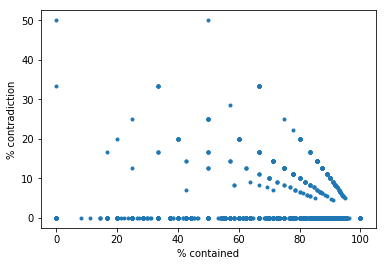

In [79]:
plt.scatter(scores[:,0], scores[:,2], marker='.')
plt.xlabel("% contained")
plt.ylabel("% contradiction")
plt.show()

# Trying BERT embeddings....

In [35]:
bert_embedding = BertEmbedding()
embed = bert_embedding(src_lines[0].split(' . '))

['relations between iran and saudi arabia have always been thorny , but rarely has the state of affairs been as venomous as it is today',
 'tehran and riyadh each point to the other as the main reason for much of the turmoil in the middle east',
 'in its most recent incarnation , the iranian-saudi conflict by proxy has reached yemen in a spiral that both sides portray as climatic',
 "for riyadh and its regional allies , the saudi military intervention in yemen -- `` operation decisive storm'' -- is the moment the sunni arab nation finally woke up to repel the expansion of shia-iranian influence",
 "for tehran and its regional allies -- including the houthi movement in yemen -- saudi arabia's actions are in defense of a retrogressive status quo order that is no longer tenable",
 'and yet both sides have good reasons to want to stop the yemeni crisis from spiraling out of control and evolving into an unwinnable war',
 'when iranian president hassan rouhani was elected in june 2013 , he p

In [51]:
embed[0][0]

['relations',
 'between',
 'iran',
 'and',
 'saudi',
 'arabia',
 'have',
 'always',
 'been',
 'thorny',
 ',',
 'but',
 'rarely',
 'has',
 'the',
 'state',
 'of',
 'affairs',
 'been',
 'as',
 'venomous']

In [54]:
# for i in range(len(embed[0][1])):
#     plt.scatter([embed[0][1][i][0]], [embed[0][1][i][1]], label=embed[0][0][i])
# # plt.scatter([embed[0][1][i][0] for i in range(len(embed[0][1]))], 
# #             [embed[0][1][i][1] for i in range(len(embed[0][1]))])
# # plt.scatter([embed[0][1][2][0]], [embed[0][1][2][1]])
# # plt.scatter([embed[0][1][4][0]], [embed[0][1][4][1]])
# # plt.scatter([embed[0][1][5][0]], [embed[0][1][5][1]])
# plt.legend()
# plt.show()

In [45]:
np.linalg.norm(embed[0][1][4] - embed[0][1][5])

10.376158

In [50]:
bert_embedding = BertEmbedding()

Vocab file is not found. Downloading.


In [63]:
i=0
with open("data/test.txt.src.tagged.shuf.400words") as src:
    with open("data/bottom_up_cnndm_015_threshold.out") as gen:
        for src_line0, gen_line0 in zip(src, gen):
            if(i >= 8):
                break
#             print(src_line0)
            i+=1

In [75]:
sentence = gen_line.split(' . ')

In [91]:
result = bert_embedding(["I ate a dog", "I ate a cat"])


In [92]:
result[0][0]

['i', 'ate', 'a', 'dog']

In [93]:
np.linalg.norm(result[1][1][3]- result[0][1][3])

6.3448873

In [94]:
np.linalg.norm(result[1][1][1]- result[0][1][1])

2.9955516